In [1]:
#"Poisson model for supercomputer failure count data"
#library(foocafeReliability)
#(Example taken from p89 of Bayesian Reliability - Hamada et al.)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pystan
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '/workspaces/bayesian-reliability/src')
from bayesian_reliability.bayesian_chi_squared_test import bayesian_chi_squared_test

In [3]:
data = {
    'shared_memory_processor_id': [val for val in range(1,48)],
    'failure_count': [1,5,1,4,2,3,1,3,6,4,4,4,2,3,2,2,4,5,5,2,5,3,2,2,3,1,1,2,5,1,4,1,1,1,2,1,3,2,5,3,5,2,5,1,1,5,2]
}
supercomputer_failures = pd.DataFrame(data)

Text(0, 0.5, 'Count')

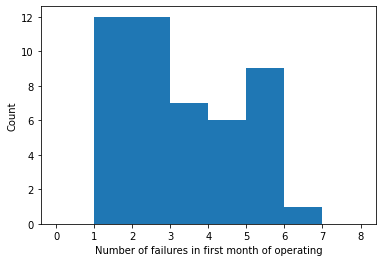

In [4]:
# Consider data
plt.hist(supercomputer_failures.failure_count, bins=[0,1,2,3,4,5,6,7,8])
plt.xlabel("Number of failures in first month of operating")
plt.ylabel("Count")

In [ ]:
# Formulate model
Consider modelling the monthly number of failures at the Los Alamos National
Laboratory Blue Mountain supercomputer components (shared memory processors or
SMPs) by a Poisson distribution.

Let $ y_1,...,y_{47} $ denote the monthly number of failures recorded for the
SMPs. With $ t_i = 1 $ month, we model the failure count data by the Poisson
distribution as:

$$
Y_i \sim \textit{Poisson}(\lambda) = \textit{Poisson}(\lambda), i = 1,...,47
$$

where $\lambda$ is the mean monthly number of failures.

# Model priors:
The supercomputer engineers expect that there should be no more than 10 failures
for each component in the first month of operation. One way to represent this
prior information is to assume a gamma prior distribution for lambda with a
mean of five. 

In [5]:
# Build model using pystan
model_code = """
  data {
    int <lower=0> Nobs;
    int <lower=0> count[Nobs];
  }

  parameters {
    real <lower=0> lambda;
  }

  model {
    count ~ poisson(lambda);

    lambda ~ gamma(5, 1);
  }
  
  generated quantities {
    //sample predicted values from the model for posterior predictive checks
    real y_rep[Nobs];
    
    for(n in 1:Nobs)
      y_rep[n] = poisson_rng(lambda);
  }
"""
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf83236f44183cc3fb69f362e7b98255 NOW.


In [6]:
data = {
    'Nobs': len(supercomputer_failures['failure_count']),
    'count': supercomputer_failures['failure_count'].tolist()
}
fit = model.sampling(data=data)

In [7]:
# Plotting and summarizing the posterior distribution
print(fit)

Inference for Stan model: anon_model_bf83236f44183cc3fb69f362e7b98255.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda      2.86  5.8e-3   0.25   2.41   2.69   2.85   3.02   3.37   1785    1.0
y_rep[1]    2.86    0.03   1.72    0.0    2.0    3.0    4.0    7.0   3618    1.0
y_rep[2]     2.9    0.03   1.73    0.0    2.0    3.0    4.0    7.0   3984    1.0
y_rep[3]    2.89    0.03   1.71    0.0    2.0    3.0    4.0    7.0   3748    1.0
y_rep[4]     2.8    0.03   1.72    0.0    2.0    3.0    4.0   6.59   4082    1.0
y_rep[5]    2.89    0.03    1.7    0.0    2.0    3.0    4.0    7.0   4034    1.0
y_rep[6]    2.87    0.03    1.7    0.0    2.0    3.0    4.0    7.0   3526    1.0
y_rep[7]    2.88    0.03   1.73    0.0    2.0    3.0    4.0    7.0   3751    1.0
y_rep[8]    2.85    0.03   1.69    0.0    2.0    3.0    4.0    7.0   3525    1.0
y

Figure(432x288)


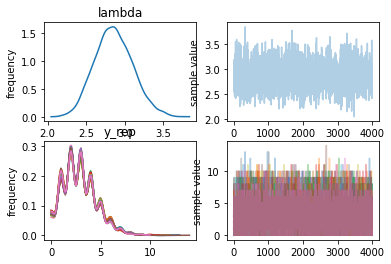

In [8]:
print(fit.plot())

# Export the samples to a data.frame for easier handling.
posterior = pd.DataFrame(fit.extract('lambda'))

In [ ]:
# Check the fit
# bayesian_chi_squared_test(
#     y = supercomputer_failures['failure_count'],
#     distribution_fun = ppois,
#     params = posterior,
#     data_type = "discrete"
# )

In [ ]:
# Evaluate goodness of fit using posterior predictive checks

Posterior predictive checks are made by simulating data from the proposed model,
then comparing a chosen test statistic (this can be the mean, maximum value,
minimum value or whatever you choose) from those simulations to the test
statistic for the actual data. If the model fits the data well we would expect
the test statistic for the simulations to be close to that of the real data.
Letting $T$ be the chosen test statistic, we can write
$$
p = Pr(T(simulations) > T(obs))
$$
where $simulations$ is the set of simulated data, and $obs$ is the actual data.
This is known as the posterior predictive p-value and the closer it lies to the
value $0.5$, the more closely test statistic for our simulations matches that of
the real data.
For example, considering the exponential model we fitted above, we can take
the mean as our test statistic, and calculate the posterior predictive p-value
as follows.

In [9]:
output_vals = fit.extract()
y = supercomputer_failures['failure_count']
y_rep = output_vals['y_rep']

In [10]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and the posterior of a parameter"""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))
    
    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--', label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--', label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()

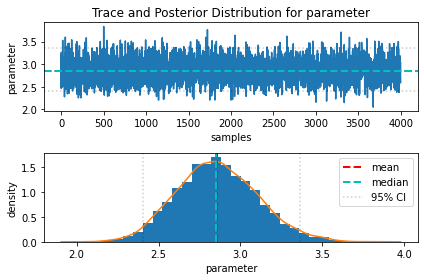

In [11]:
plot_trace(output_vals['lambda'])

In [12]:
# Taking the mean to be the test statistic:
sum(output_vals['y_rep'].mean(1) > np.mean(y)) / len(output_vals['y_rep'])

0.538

(array([   7.,  184.,  984., 1382.,  904.,  374.,  127.,   26.,    8.,
           4.]),
 array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]),
 <BarContainer object of 10 artists>)

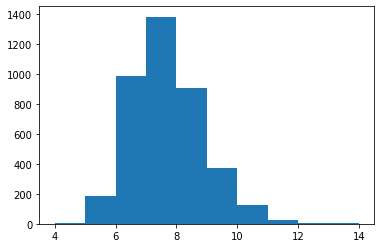

In [13]:
plt.hist(output_vals['y_rep'].max(1).tolist())

In [15]:
# Taking max to be the test statistic:
sum(output_vals['y_rep'].max(1) > np.max(y)) / len(output_vals['y_rep'])

0.70625

In [14]:
def ppc(test_statistic):
    """Plot the posterior predictive p-value of a parameter"""

    if test_statistic == 'mean':
        pp_vals = output_vals['y_rep'].mean(1)
        actual_val = np.mean(y)
    elif test_statistic == 'max':
        pp_vals = output_vals['y_rep'].max(1)
        actual_val = np.max(y)

    plt.subplot(2,1,2)
    plt.hist(pp_vals, density=True)
    plt.axvline(actual_val, color='r', lw=2, linestyle='--', label='mean')
    
    plt.gcf().tight_layout()
    plt.legend()

In [16]:
print(ppc(test_statistic='mean'))

None


In [17]:
print(ppc(test_statistic='max'))

None


In [18]:
def ppc_dens_overlay(y_actual, y_rep):    
    plt.subplot(2,1,2)
    for y in y_rep:
        sns.kdeplot(y, color='skyblue')
    sns.kdeplot(y_actual)
    plt.gcf().tight_layout()
    plt.legend()

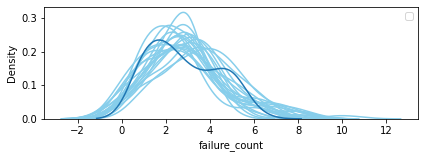

In [19]:
ppc_dens_overlay(y, output_vals['y_rep'][0:20])

In [20]:
y = supercomputer_failures['failure_count'].tolist()
params = output_vals['lambda']
bayesian_chi_squared_test(y, params)

4.125